# Equivilent Width

This notebook compares pseudo-equivilent widths (pW) between CMFGEN models and CSP spectroscopy. pW values are determine according to the prescription set forth in the CSP DR1 data release Folatelli et al. 2013. For each feature, "the pW is obtained by defining a straight 'continuum' level between two neighboring flux peaks and computing the integral of the spectrum flux relative to the continuum" (Folatelli 2013).


In [1]:
import sys

import sncosmo
from astropy.table import Table, join
from matplotlib import pyplot as plt
from sndata.csp import dr1
from specutils.analysis import equivalent_width
from specutils.fitting import fit_generic_continuum

sys.path.insert(0, '../')
from analysis import equivalent_width as ew
from analysis import models


In [2]:
models.register_sources(force=True)
dr1.download_module_data()

# Load models for different masses
m102 = sncosmo.get_source('CMFGEN', version=1.02)
m104 = sncosmo.get_source('CMFGEN', version=1.04)
m14 = sncosmo.get_source('CMFGEN', version=1.4)
m17 = sncosmo.get_source('CMFGEN', version=1.7)


In [3]:
def get_spectra_for_id(obj_id):
    """Get spectral data for a given data id

    Args:
        obj_id (str): The ID of the desired object

    Returns:
        A list of observed MJD dates for each spectra
        A 2d list of wavelength values for each date
        A 2d list of flux values for each date
    """

    data = dr1.get_data_for_id(obj_id)
    obs_dates = list(set(data['date']))

    wavelength, flux = [], []
    for date in obs_dates:
        data_for_date = data[data['date'] == date]
        wavelength.append(data_for_date['wavelength'])
        flux.append(data_for_date['flux'])

    return obs_dates, wavelength, flux


def plot_spectra(obs_dates, wavelength, flux, **kwargs):
    """Plot spectra
    
    Args:
        obs_dates  (list): A list of observed MJD dates for each spectra
        wavelength (list): A 2d list of wavelength values for each date
        flux       (list): A 2d list of flux values for each date
        Any other arguments for ``axis.plot``
    """
    
    fig, axis = plt.subplots(1, 1, figsize=(10, 10))    
    plot_data = zip(obs_dates, wavelength, flux)
    for i, (date, wave, flux) in enumerate(plot_data):
        axis.plot(wave, flux + i * 2e-15, label=str(date), **kwargs)
        axis.legend()
    
    return fig, axis


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c254fa5c0>)

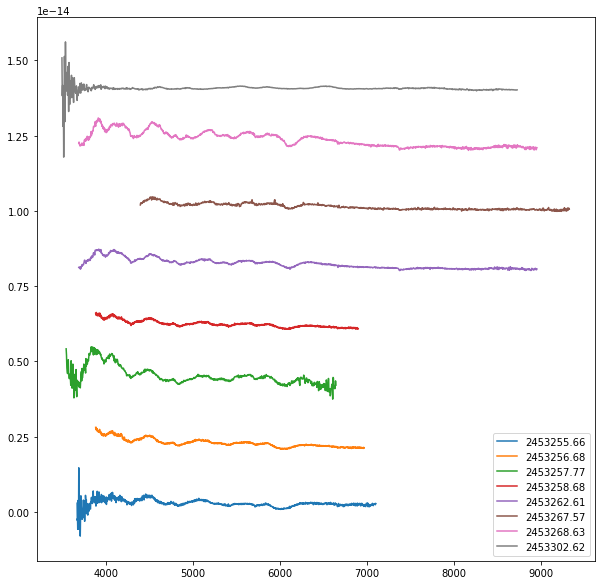

In [4]:
plot_spectra(*get_spectra_for_id('2004ef'))


## Fitting the Continuum

We consider the same set of features considered in Folatelli et al. 2013.

In [5]:
ew.feature_table

feature_name,feature_id,lower_blue,upper_blue,lower_red,upper_red
str3,str17,int64,int64,int64,int64
pW1,Ca ii H&K,3500,3800,3900,4100
pW2,Si ii λ4130,3900,4000,4000,4150
pW3,"Mg ii, Fe ii",3900,4150,4450,4700
pW4,"Fe ii, Si ii",4500,4700,5050,5550
pW5,"S ii λ5449, λ5622",5150,5300,5500,5700
pW6,Si ii λ5972,5550,5700,5800,6000
pW7,Si ii λ6355,5800,6000,6200,6600
pW8,Ca ii IR triplet,7500,8000,8200,8900


In [6]:
def plot_ew(obs_dates, wavelength, flux, feature_table, **kwargs):
    """
    
    Args:
        obs_dates      (list): A list of observed MJD dates for each spectra
        wavelength     (list): A 2d list of wavelength values for each date
        flux           (list): A 2d list of flux values for each date
        feature_table (Table): A table defining spectral features
        Any other arguments for ``axis.plot``
    """

    fig, axis = plot_spectra(obs_dates, wavelength, flux)

    for i, (time, wave, fluxx) in enumerate(zip(obs_dates, wavelength, flux)):
        for feature in ew.feature_table:
            try:
                feat_wave, feat_flux = ew.get_feature_coordinates(wave, fluxx, feature)

            except ew.UnobservedFeature:
                continue

            # Get observed wavelength and flux for each feature
            indices = (feat_wave[0] < wave) & (wave < feat_wave[1])
            spectral_wave = wave[indices]
            spectral_flux = fluxx[indices]
            
            # Get continuum and plot
            cont_func = ew.get_continuum_func(*feat_wave, *feat_flux)
            continuum_flux = cont_func(spectral_wave)
            axis.fill_between(
                spectral_wave,
                spectral_flux + i * 2e-15,
                continuum_flux + i * 2e-15, 
                color='grey', 
                alpha=.75)
            

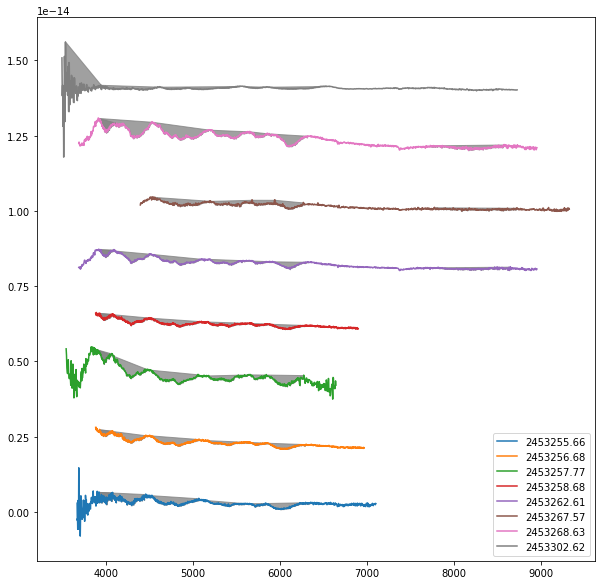

In [7]:
plot_ew(*get_spectra_for_id('2004ef'), ew.feature_table)

## Validating Against CSP

We compare our equivilent width results with values published by CSP. The first 10 rows of the published data is shown for reference.


In [8]:
csp_ew_table = dr1.load_table(6)
summary_table = dr1.load_table(1)
csp_results = join(csp_ew_table, summary_table['SN', 'T0'], keys='SN')
csp_results.sort('SN')

print('Table description:', csp_ew_table.meta['description'])
csp_results[:10]


Table description: Values of pW at B-band maximum light


Cl,SN,pW1,e_pW1,pW2,e_pW2,pW3,e_pW3,pW4,e_pW4,pW5,e_pW5,pW6,e_pW6,pW7,e_pW7,pW8,e_pW8,T0
,,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,0.1 nm,d
str2,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
BL,2004dt,140.4,8.0,24.3,0.5,111.6,2.8,118.8,2.7,72.6,0.9,20.2,0.9,172.7,1.9,134.9,5.8,53239.1
BL,2004ef,155.0,1.2,27.1,0.9,108.3,2.5,186.8,2.5,86.5,2.5,26.2,1.2,131.3,2.1,158.1,33.4,53264.0
CL,2004eo,127.7,16.3,32.2,2.6,142.7,1.6,165.8,6.9,82.1,0.8,37.1,2.5,117.4,5.7,192.7,15.4,53278.2
CN,2004ey,107.2,5.3,13.6,1.5,96.8,1.5,129.9,3.2,91.1,3.3,14.2,1.1,99.7,3.5,65.0,16.5,53303.9
CL,2004gs,105.7,7.9,35.3,1.9,104.5,9.1,197.9,3.5,87.4,2.3,47.8,3.1,134.1,1.9,243.1,18.9,53356.0
SS,2004gu,69.3,4.2,3.0,1.0,103.7,4.9,128.6,3.0,72.8,1.9,4.5,1.2,67.2,1.8,179.4,27.6,53363.4
BL,2005A,210.0,21.8,21.8,1.9,128.2,2.5,306.2,10.9,58.6,12.6,14.0,1.8,142.6,3.1,400.9,18.4,53380.4
SS,2005M,100.4,12.5,9.6,1.4,94.9,6.2,141.7,6.0,71.5,3.0,12.0,3.2,54.7,4.0,59.3,23.8,53405.4


In [9]:
analysis_results = ew.tabulate_pew(*get_spectra_for_id('2004ey'), ew.feature_table)
analysis_results['time'] -= 2400000 + csp_results['T0'][csp_results['SN'] == '2004ey']
analysis_results


time,pW1,pW2,pW3,pW4,pW5,pW6,pW7,pW8
float64,float64,float64,float64,float64,float64,float64,float64,float64
48.62999999988824,--,10.287751786959912,344.1259486994137,431.2114051270797,34.980590593120894,92.30258444667538,255.9698643045383,541.1908156207378
44.62999999988824,--,10.075960157191304,304.69088037050636,409.8676052783902,31.501050043823426,81.12257623349117,256.1679082413147,510.378146797778
-0.3399999998509884,--,25.76282464818364,142.74210990256472,157.71227831141812,117.23088771866611,35.5994637276786,126.81885281060443,--
31.66000000014901,--,16.949899287829147,367.86402290894944,462.02075724138564,43.50058500437885,73.34537139915693,250.5098706834989,--


## Comparing CMFGEN Against Observations

In [10]:
sources = (m102, m104, m14 , m17)
ew_results = ew.compare_target_and_models(*get_spectra_for_id('2004ef'), ew.feature_table, sources)
ew_results


time,pW1,pW2,pW3,pW4,pW5,pW6,pW7,pW8,time_C1.02,pW1_C1.02,pW2_C1.02,pW3_C1.02,pW4_C1.02,pW5_C1.02,pW6_C1.02,pW7_C1.02,pW8_C1.02,time_C1.04,pW1_C1.04,pW2_C1.04,pW3_C1.04,pW4_C1.04,pW5_C1.04,pW6_C1.04,pW7_C1.04,pW8_C1.04,time_C1.4,pW1_C1.4,pW2_C1.4,pW3_C1.4,pW4_C1.4,pW5_C1.4,pW6_C1.4,pW7_C1.4,pW8_C1.4,time_C1.7,pW1_C1.7,pW2_C1.7,pW3_C1.7,pW4_C1.7,pW5_C1.7,pW6_C1.7,pW7_C1.7,pW8_C1.7
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2453255.66,--,56.721491546136136,189.3879909730722,209.94629063360406,106.81824493836876,46.56883412534478,200.95974850383345,--,2453255.66,--,4.820099999999911,453.271379084676,242.40836878448943,41.55527608037556,176.97871051193414,234.92497186437618,--,2453255.66,--,2.4099999999998545,467.5789566657788,116.97128768609292,34.32535636491531,172.11888885019675,274.51768413430125,--,2453255.66,--,4.9776937062883775,391.3737352377235,247.81491283344974,41.090194966201665,177.4186707836214,217.53091425698125,--,2453255.66,--,4.813776675579037,499.2134826838143,125.9462449518175,49.1581995684374,181.37737165251147,316.56834876425864,--
2453256.68,--,27.23762834538489,131.40184719378203,196.8581490646153,96.49949994036126,33.18073946249382,176.742913626384,--,2453256.68,--,3.0192000000001826,451.05710588130415,240.52927925176186,40.5814272247232,175.64127957939812,232.9428435622799,--,2453256.68,--,3.0192000000001826,466.1106607118773,115.68708868812294,33.29749290001291,170.15336233596983,272.925157901959,--,2453256.68,--,3.168908087409392,389.4113760465039,246.25777718472386,40.17564271089543,175.98320084258063,215.6295543301702,--,2453256.68,--,3.017021142142955,496.94643052884544,124.21603025913618,48.71357357262531,179.7622967834423,314.83436639607896,--
2453257.77,--,29.80356964588492,135.38362795064427,205.45578121449842,102.18252867779637,40.05381062182201,173.546480086435,--,2453257.77,--,8.13590000000022,457.1391537789035,244.8725153981926,43.942542603397726,178.0995292033346,237.86563506876035,--,2453257.77,--,8.13590000000022,471.8125200748665,120.94999715420502,38.968921156819846,172.45257636026216,277.9767311860452,--,2453257.77,--,8.20045497606996,392.9653966602982,251.18430818557943,44.02533014030618,177.86690280804316,220.6412947277729,--,2453257.77,--,8.122847814265617,502.4471600470075,128.95826243443264,51.908527809192805,181.39966157762467,319.88993880685814,--
2453258.68,--,32.69375796504737,150.5072984964612,200.20132147959373,122.54354690522496,37.88541474806124,169.41789433368774,--,2453258.68,--,3.018800000000283,451.0957171914707,240.43294572495103,40.23016976310629,175.92802039332543,232.86140127629233,--,2453258.68,--,1.509400000000369,465.41002058377086,115.65524102100198,32.88281989789539,170.45597015790423,272.8675005138988,--,2453258.68,--,3.1700653786496815,389.45818624527413,246.17958838131824,39.86945901742985,176.06434015971553,215.6828975108187,--,2453258.68,--,3.0166230504321883,496.9769387950846,124.22280852115935,48.27972492002823,180.10467262572396,314.76062234399996,--
2453262.61,--,35.65774149441407,141.05951076111313,184.37503729300602,106.72162224267868,39.87310718763001,149.4202268873628,360.61884678862407,2453262.61,--,5.900000000000091,454.8499509347941,243.88714572245345,42.897076140749334,179.23203052471524,235.78385335848998,595.8133422061312,2453262.61,--,2.949999999999818,468.5581959945465,118.49970037435872,34.35598696657701,173.10335327617133,275.85843341084524,495.20005457996365,2453262.61,--,6.123418879340932,392.7581746499813,249.2367260071461,41.833153508918855,179.1626577055354,218.5710131779232,585.8114277430024,2453262.61,--,5.896971222103385,499.99150217394373,127.01922380814622,49.26405464934504,183.10145276553823,317.50312022595585,654.02